In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import matplotlib.colors as colors
# plt.style.use('presentation_style')


### Stats xplor

1) Figure out how to add wieghts to sqr ✅ 

2) ~~Figure out how to compute cov matrix from err landscape~~

3) Implement scipy fitting on single data set  ✅ 

5) Figure out how to get error of ellipse from pcov matrix ✅ 

5) ~~Compare pcov and first principles ellipses of error~~

6) ~~Compare full results from both methods to see whats really going on under the curve_fit hood~~






In [591]:
def sin_func(t, A_0, A, f, phi):
    return A_0 + A * np.sin(2 * np.pi * f * t + phi)




### Bootstrapping proceedure

1) Generate a single measurement and fit it using curve fit  ✅ 

2) Reserach how error propagates  ✅ 

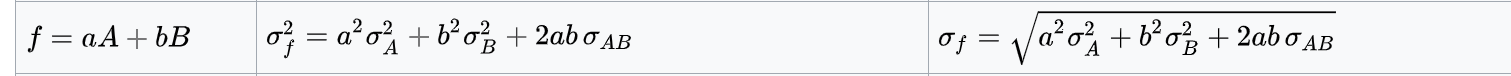

so for this phase eqn: __2pi*f*t +phi__
We get: __var_phase = ((2pi*t)^2 * var_f) + (var_phi) + (2cov_f_phi * 2pi*t)__

3) Implement how error propagates and find where unc is less than 2pi

4) Generate a double slit measurement with the desired spacing from the prev step. Look only at the second window and do a fit (only to this part so that we dont get phase-freq correlated striping)

5) The Phase fit should be allowed to vary as much as possible but at the end you should mod 2pi it

6) Once the phase fit is grabbed (its relative to the center of the measurement window) add this phase to each multiple of 2pi on the error prop graph. Whichever resulting point lies in the cone of error is the new point. 

7) Re-fit the data using the averaged frequency fits from both fits as the init seed. Then once you get the line look at the error in the slope and intercept. 



In [129]:
f_1 = 25
tau_1 = 1 / f_1
width1 = 2 * tau_1

class Fringe:
    def __init__(self, A_0, A, f_0, phi):
        self.f_0 = f_0
        self.A_0 = A_0
        self.A = A
        self.phi = phi

    def eval_pure(self, t):
        return self.A_0 + self.A * np.sin(2 * np.pi * self.f_0 * t + self.phi)

    def add_noise(self, data, noise_level):
        noise = np.random.normal(0, noise_level, size=data.shape)
        return data + noise
    
    def eval_noisy(self, t, noise_level=0.6):
        data_pure = self.eval_pure(t)
        data1 = self.add_noise(np.array(data_pure), noise_level)
        data2 = self.add_noise(np.array(data_pure), noise_level)
        data3 = self.add_noise(np.array(data_pure), noise_level)
        data4 = self.add_noise(np.array(data_pure), noise_level)
        data5 = self.add_noise(np.array(data_pure), noise_level)

        all_data = np.array([data1, data2, data3, data4, data5])
        data_avg = np.mean(all_data, axis=0)
        data_err = np.sqrt(np.sum((all_data-data_avg)**2, axis=0)
                           /(5*(5-1))
                           )

        return data_avg, data_err

def gen_sample(fringe, t_hold_center, f_samp, no_samp, noise_level=0.2):
    if no_samp % 2 == 0:
        raise ValueError("no_samp must be odd")
    dt = 1 / f_samp
    half_span = (no_samp - 1) // 2 * dt
    t_range = np.linspace(t_hold_center - half_span, 
                          t_hold_center + half_span, 
                          no_samp)
    avg, err = fringe.eval_noisy(t_range, noise_level=noise_level)
    # print(t_range)
    return t_range, avg, err


In [561]:

want_no_samp = 9
f_samp1 = f_1 * np.e*1.5
center_t1_hold = 0
little_g_fringe = Fringe(A_0=0, A=.15, f_0=f_1, phi=0)
t01s, avg01s, err01s = gen_sample(little_g_fringe, center_t1_hold, f_samp1, want_no_samp, noise_level=0.3)
print(err01s)

[0.0590045  0.12930935 0.08190994 0.26122942 0.108947   0.06126339
 0.15988865 0.13664227 0.1585362 ]


In [562]:
sine_fit_bounds = ([ -np.inf, 0, 0, -np.inf],
                   [ np.inf, 1, f_samp1/2, np.inf])

[[ 1.44435764e-03 -1.12697269e-03  2.55034400e-03 -2.35488977e-03]
 [-1.12697269e-03  4.51086745e-03  3.24246043e-02 -2.94959700e-03]
 [ 2.55034400e-03  3.24246043e-02  4.14952093e+00  1.21087289e-01]
 [-2.35488977e-03 -2.94959700e-03  1.21087289e-01  1.01876894e-01]]


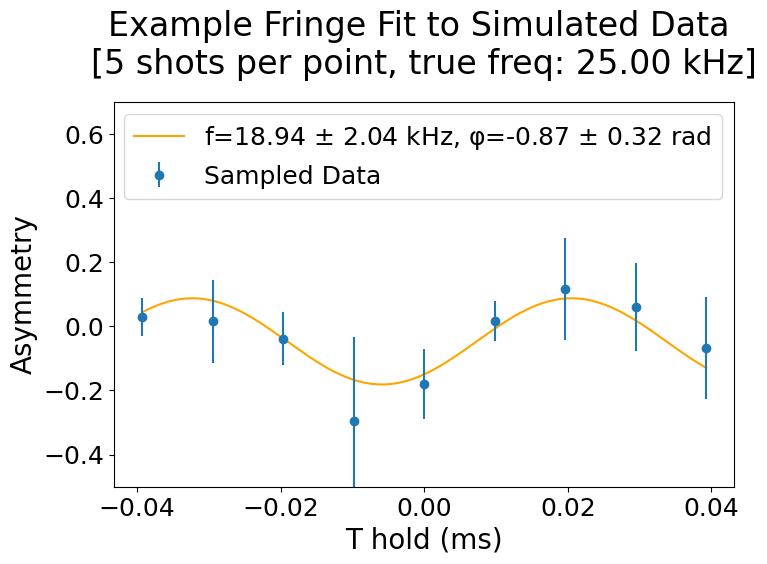

In [563]:
plt.figure(figsize=(8, 5))

popt1, pcov1 = curve_fit(sin_func, t01s, avg01s, p0=[0, .15, f_1, 0], sigma=err01s, absolute_sigma=True, bounds=sine_fit_bounds)
plot_t1s = np.linspace(t01s[0], t01s[-1], 1000)
fringe_fit = sin_func(plot_t1s, *popt1)
plt.plot(plot_t1s, fringe_fit, label=rf'f={popt1[2]:.2f} $\pm$ {np.sqrt(pcov1[2,2]):.2f} kHz, φ={popt1[3]:.2f} $\pm$ {np.sqrt(pcov1[3,3]):.2f} rad', color='orange')
plt.errorbar(t01s, avg01s, yerr=err01s, fmt='o', label='Sampled Data')
# plt.axvline(center_t1_hold*1e3, color='r', linestyle='--', label='Hold Time Center')
plt.ylim(-.5, 0.7)
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.legend(fontsize=18)
plt.title(f'Example Fringe Fit to Simulated Data \n[5 shots per point, true freq: {f_1:.2f} kHz]', pad=20, fontsize=24)
print(pcov1)


In [564]:
true_f = little_g_fringe.f_0 
true_phi_0 = little_g_fringe.phi

In [565]:
def phase_prop(t_range, f, phi):
    return 2 * np.pi * f * t_range + phi

def phase_error_prop(t_range, var_f, var_phi, cov_f_phi):
    var_phase = ((2 * np.pi * t_range)**2 * var_f) + (var_phi) + (2 * cov_f_phi * 2 * np.pi * t_range)
    return np.sqrt(var_phase)


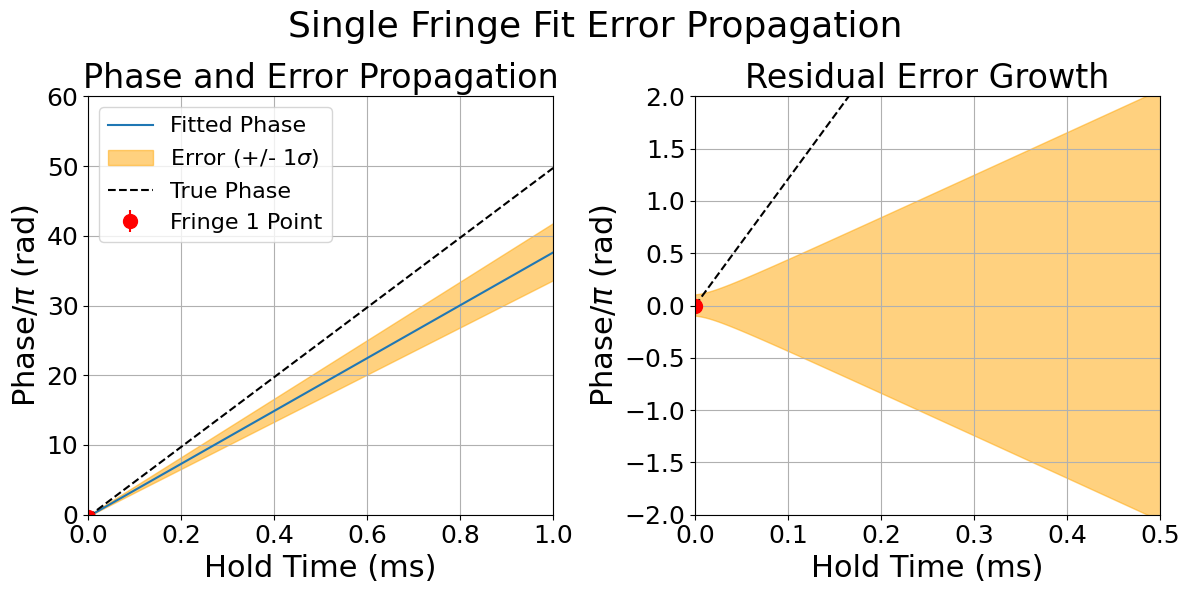

In [566]:

freq_fit = popt1[2]
phi_fit = popt1[3]
freq_var = pcov1[2, 2]
phi_var = pcov1[3, 3]
freq_phi_cov = pcov1[2, 3]

# print(pcov1)

t_range_prop = np.linspace(0, 100*tau_1, 10000)
true_phase = phase_prop(t_range_prop-center_t1_hold, true_f, phi_fit)


phase_fit = phase_prop(t_range_prop-center_t1_hold, freq_fit, phi_fit)
phase_error_true = phase_error_prop(t_range_prop-center_t1_hold, freq_var, phi_var, freq_phi_cov)
phase_error_abscov = phase_error_prop(t_range_prop-center_t1_hold, freq_var, phi_var, np.abs(freq_phi_cov))
phase_error_0cov = phase_error_prop(t_range_prop-center_t1_hold, freq_var, phi_var, 0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))#, constrained_layout=True)
ax[0].plot(t_range_prop, phase_fit/(np.pi), label='Fitted Phase')
ax[0].fill_between(t_range_prop, (phase_fit - phase_error_true)/(np.pi), (phase_fit + phase_error_true)/(np.pi), color='orange', alpha=0.5, label=r'Error (+/- 1$\sigma$)')
# ax[0].fill_between(t_range_prop, (phase_fit + phase_error_0cov)/(np.pi), (phase_fit-phase_error_0cov)/(np.pi), label=r'Error w/0 cov (+/- 1$\sigma$)', color='blue', alpha=0.2)
# ax[0].fill_between(t_range_prop*1e3, (phase_fit + phase_error_abscov)/(np.pi), (phase_fit-phase_error_abscov)/(np.pi), label=r'Fitted Phase Error w/ |cov| (+/- 1$\sigma$)', color='green', alpha=0.2)
ax[0].plot(t_range_prop, true_phase/(np.pi), label='True Phase', color='black', linestyle='--')
ax[0].set_xlabel('Hold Time (ms)', fontsize=22)
ax[0].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=22)

ax[0].set_title('Phase and Error Propagation', fontsize=24)
# ax[0].axvline(1.2, color='green', linestyle='--', label='1.2 ms')
ax[0].errorbar(center_t1_hold*1e3, (phi_fit)/(np.pi), yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point', markersize=10)

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0,60)
ax[0].grid()
ax[0].legend(fontsize=16)

ax[1].fill_between(t_range_prop, phase_error_true/(np.pi), -1*phase_error_true/(np.pi), label=r'Fitted Phase Error (+/- 1$\sigma$)', color='orange', alpha=0.5)
# ax[1].fill_between(t_range_prop*1e3, phase_error_abscov/(np.pi), -1*phase_error_abscov/(np.pi), label=r'Fitted Phase Error w/ |cov| (+/- 1$\sigma$)', color='green', alpha=0.2)
# ax[1].fill_between(t_range_prop, phase_error_0cov/(np.pi), -1*phase_error_0cov/(np.pi), label=r'Fitted Phase Error w/o cov (+/- 1$\sigma$)', color='blue', alpha=0.2)

ax[1].errorbar(center_t1_hold, 0, yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point - Phi_fit', markersize=10)
ax[1].plot(t_range_prop, (true_phase-phase_fit)/(np.pi), label='True Phase Residual', color='black', linestyle='--')
ax[1].set_xlabel('Hold Time (ms)', fontsize=22)
ax[1].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=22)
ax[1].set_xlim(0, .5)
ax[1].set_ylim(-2, 2)
ax[1].set_title('Residual Error Growth', fontsize=24)
# ax[1].axhline(1, color='red', linestyle='--', label=r'+$\pi$')
# ax[1].axhline(-1, color='red', linestyle='--', label=r'-$\pi$')
# ax[1].axvline(3, color='green', linestyle='--')
# ax[1].axvline(2, color='green', linestyle='--')
# ax[1].axvline(1.2, color='green', linestyle='--')

ax[1].grid()
# ax[1].legend()

fig.suptitle('Single Fringe Fit Error Propagation', fontsize=26)
fig.tight_layout()

In [567]:
print(np.sqrt(phi_var)/np.pi)

0.10159865900490303


In [568]:
t2_center = .1
t02s, avg02s, std02s = gen_sample(little_g_fringe, t2_center, f_samp1, want_no_samp)

3.7038825737154695


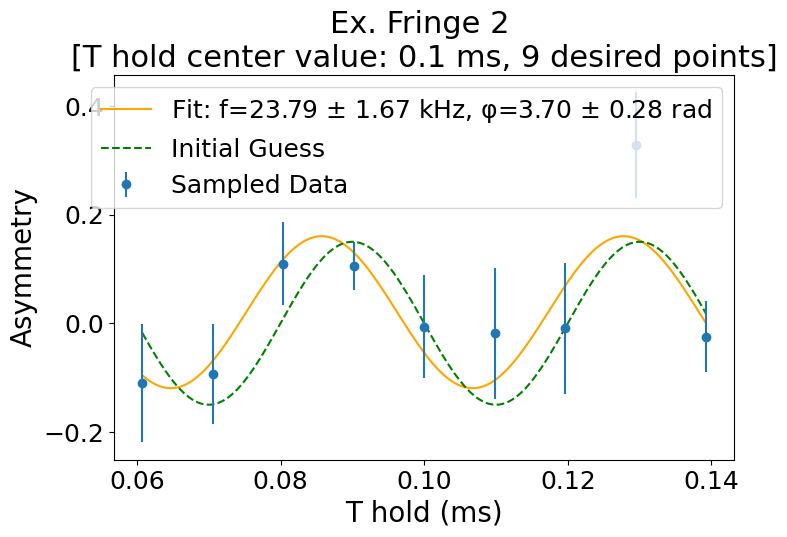

In [569]:
p_init_2 = [0, .15, f_1, np.pi]
popt2, pcov2 = curve_fit(sin_func, t02s-t2_center, avg02s, p0=p_init_2, sigma=std02s, absolute_sigma=True, bounds=sine_fit_bounds)
plot_t2s = np.linspace(t02s[0], t02s[-1], 1000)
fringe_fit = sin_func(plot_t2s-t2_center, *popt2)
freq_fit2 = popt2[2]
phi_fit2 = popt2[3]
freq_var2 = pcov2[2, 2]
phi_var2 = pcov2[3, 3]
freq_phi_cov2 = pcov2[2, 3]

print(phi_fit2)
plt.figure(figsize=(8, 5))
plt.plot(plot_t2s, fringe_fit, color='orange', label=rf'Fit: f={freq_fit2:.2f} $\pm$ {np.sqrt(freq_var2):.2f} kHz, φ={phi_fit2:.2f} $\pm$ {np.sqrt(phi_var2):.2f} rad')
plt.plot(plot_t2s, sin_func(plot_t2s-t2_center, *p_init_2), label='Initial Guess', color='green', linestyle='--')
plt.errorbar(t02s, avg02s, yerr=std02s, fmt='o', label='Sampled Data')
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.title(f'Ex. Fringe 2 \n[T hold center value: {t2_center:.1f} ms, {want_no_samp} desired points]')
plt.legend(fontsize=18)

In [570]:
t3_center = .2
t03s, avg03s, std03s = gen_sample(little_g_fringe, t3_center, f_samp1, want_no_samp)

[ 0.0469281   0.26362068 24.42202943 -0.34198515]


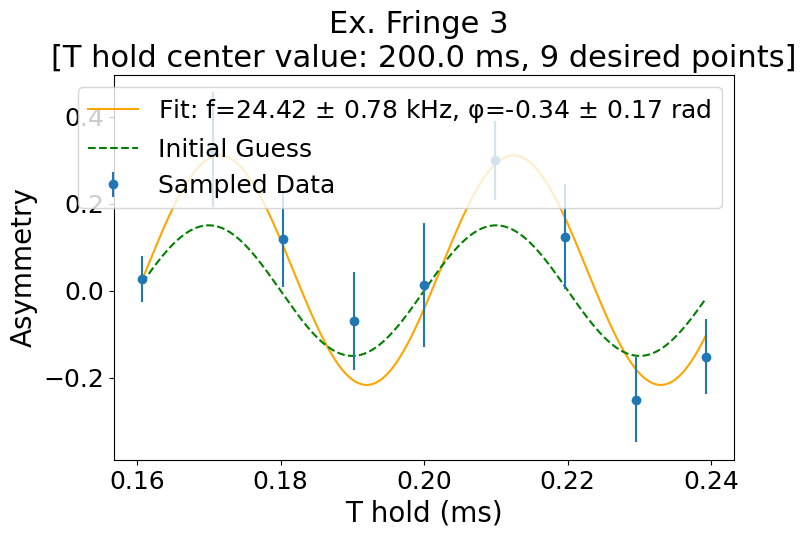

In [571]:
p_init_3 = [0, .15, f_1, 0]
popt3, pcov3 = curve_fit(sin_func, t03s-t3_center, avg03s, p0=p_init_3, sigma=std03s, absolute_sigma=True, bounds=sine_fit_bounds)
plot_t3s = np.linspace(t03s[0], t03s[-1], 1000)
fringe_fit = sin_func(plot_t3s-t3_center, *popt3)
freq_fit3 = popt3[2]
phi_fit3 = popt3[3]
freq_var3 = pcov3[2, 2]
phi_var3 = pcov3[3, 3]
freq_phi_cov3 = pcov3[2, 3]

plt.figure(figsize=(8, 5))
plt.plot(plot_t3s, fringe_fit, color='orange', label=rf'Fit: f={freq_fit3:.2f} $\pm$ {np.sqrt(freq_var3):.2f} kHz, φ={phi_fit3:.2f} $\pm$ {np.sqrt(phi_var3):.2f} rad')
plt.plot(plot_t3s, sin_func(plot_t3s-t3_center, *p_init_3), label='Initial Guess', color='green', linestyle='--')
plt.errorbar(t03s, avg03s, yerr=std03s, fmt='o', label='Sampled Data')
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.title(f'Ex. Fringe 3 \n[T hold center value: {t3_center*1e3:.1f} ms, {want_no_samp} desired points]')
plt.legend(fontsize=18)

print(popt3)

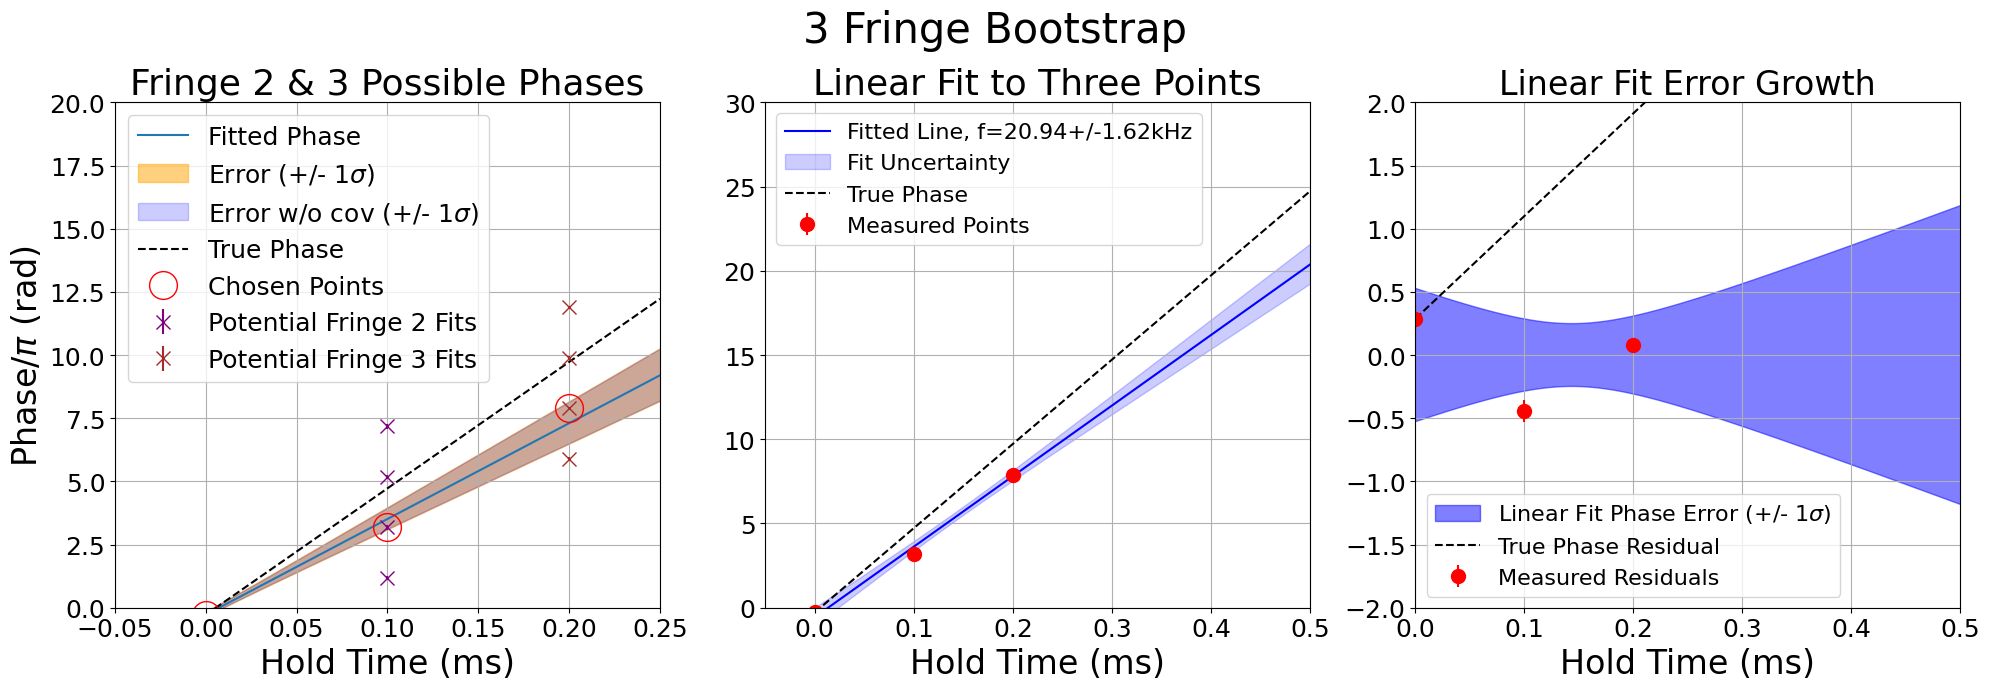

In [573]:
potential_phi2s = np.array([0, 2, 4, 6])*np.pi + phi_fit2
pot_phi2_xs = np.ones_like(potential_phi2s) * t2_center


potential_phi3s = np.array([6,8,10,12])*np.pi + phi_fit3
pot_phi3_xs = np.ones_like(potential_phi3s) * t3_center



fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(t_range_prop, phase_fit/(np.pi), label='Fitted Phase')
ax[0].fill_between(t_range_prop, (phase_fit - phase_error_true)/(np.pi), (phase_fit + phase_error_true)/(np.pi), color='orange', alpha=0.5, label=r'Error (+/- 1$\sigma$)')
ax[0].fill_between(t_range_prop, (phase_fit + phase_error_0cov)/(np.pi), (phase_fit-phase_error_0cov)/(np.pi), label=r'Error w/o cov (+/- 1$\sigma$)', color='blue', alpha=0.2)
# ax[0].fill_between(t_range_prop*1e3, (phase_fit + phase_error_abscov)/(np.pi), (phase_fit-phase_error_abscov)/(np.pi), label=r'Fitted Phase Error w/ |cov| (+/- 1$\sigma$)', color='green', alpha=0.2)
ax[0].errorbar(pot_phi2_xs, potential_phi2s/(np.pi), yerr=np.sqrt(phi_var2)/(np.pi), fmt='x', label='Potential Fringe 2 Fits', color='purple', markersize=10)
ax[0].errorbar(pot_phi3_xs, potential_phi3s/(np.pi), yerr=np.sqrt(phi_var3)/(np.pi), fmt='x', label='Potential Fringe 3 Fits', color='brown', markersize=10)
ax[0].plot(t_range_prop, true_phase/(np.pi), label='True Phase', color='black', linestyle='--')
ax[0].set_xlabel('Hold Time (ms)', fontsize=24)
ax[0].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=24)

ax[0].set_title('Fringe 2 & 3 Possible Phases', fontsize=26)
# ax[0].axvline(1.2, color='green', linestyle='--', label='1.2 ms')
# ax[0].errorbar(center_t1_hold*1e3, (phi_fit)/(np.pi), yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point', markersize=10)



good_phi3 = potential_phi3s[1]
good_phi3_x = t3_center
good_phi3_std = np.sqrt(phi_var3)

good_phi2 = potential_phi2s[1]
good_phi2_x = t2_center
good_phi2_std = np.sqrt(phi_var2)

good_phi1 = phi_fit
good_phi1_x = center_t1_hold
good_phi1_std = np.sqrt(phi_var)


phi_lin_fit_x_data = np.array([good_phi1_x, good_phi2_x, good_phi3_x])
phi_lin_fit_y_data = np.array([good_phi1, good_phi2, good_phi3])
phi_lin_fit_y_err = np.array([good_phi1_std, good_phi2_std, good_phi3_std])

ax[0].plot(phi_lin_fit_x_data, phi_lin_fit_y_data/np.pi, 'o', label='Chosen Points', color='red', markersize=20, markerfacecolor='none')

ax[0].set_xlim(-0.05, .25)
ax[0].set_ylim(0,20)
ax[0].grid()
ax[0].legend(fontsize=18)



# Fit line to data
popt_lin1, pcov_lin1 = curve_fit(phase_prop, phi_lin_fit_x_data, phi_lin_fit_y_data, sigma=phi_lin_fit_y_err)
f_lin_fit, p_lin_fit = popt_lin1
f_lin_var, p_lin_var = np.diag(pcov_lin1)
fp_lin_cov = pcov_lin1[0, 1]

phase_prop_lin_fit = phase_prop(t_range_prop, f_lin_fit, p_lin_fit)
error_prop_lin_fit = phase_error_prop(t_range_prop, f_lin_var, p_lin_var, fp_lin_cov)
residuals = phi_lin_fit_y_data - phase_prop(phi_lin_fit_x_data, f_lin_fit, p_lin_fit)

ax[1].errorbar(phi_lin_fit_x_data, phi_lin_fit_y_data/np.pi, yerr=phi_lin_fit_y_err/np.pi, fmt='o', label='Measured Points', color='red', markersize=10)
ax[1].plot(t_range_prop, phase_prop_lin_fit/np.pi, label=f'Fitted Line, f={f_lin_fit:.2f}+/-{np.sqrt(f_lin_var):.2f}kHz', color='blue')
ax[1].fill_between(t_range_prop, (phase_prop_lin_fit - error_prop_lin_fit)/np.pi, (phase_prop_lin_fit + error_prop_lin_fit)/np.pi, color='blue', alpha=0.2, label='Fit Uncertainty')
ax[1].plot(t_range_prop, (true_phase)/np.pi, label='True Phase', color='black', linestyle='--')
ax[1].set_xlabel('Hold Time (ms)', fontsize=24)
# ax[1].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=24)  
ax[1].set_title('Linear Fit to Three Points', fontsize=26)
ax[1].legend(fontsize=16)
ax[1].grid()
ax[1].set_xlim(-0.05, .5)
ax[1].set_ylim(0,30)

ax[2].fill_between(t_range_prop, error_prop_lin_fit/np.pi, -1*error_prop_lin_fit/np.pi, label=r'Linear Fit Phase Error (+/- 1$\sigma$)', color='blue', alpha=0.5)
ax[2].errorbar(phi_lin_fit_x_data, residuals/np.pi, yerr=phi_lin_fit_y_err/np.pi, fmt='o', label='Measured Residuals', color='red', markersize=10)
ax[2].plot(t_range_prop, (true_phase - phase_prop_lin_fit)/np.pi, label='True Phase Residual', color='black', linestyle='--')
ax[2].set_xlabel('Hold Time (ms)', fontsize=24)
# ax[2].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=24)
ax[2].set_title('Linear Fit Error Growth', fontsize=24)
ax[2].set_xlim(0, .5)
ax[2].set_ylim(-2, 2)
ax[2].grid()
ax[2].legend(fontsize=16)



fig.suptitle('3 Fringe Bootstrap', fontsize=30)
plt.tight_layout()



In [574]:
def fit_sin_and_plot(ts, avgs, stds, t_center, p_init, title_suffix):
    p_init_temp = [0, .15, f_1, 0]
    popt_temp, pcov_temp = curve_fit(sin_func, ts-t_center, avgs, p0=p_init_temp, sigma=stds, absolute_sigma=True, bounds=sine_fit_bounds)
    plot_ts = np.linspace(ts[0], ts[-1], 1000)
    fringe_fit = sin_func(plot_ts-t_center, *popt_temp)
    freq_fit_temp = popt_temp[2]
    phi_fit_temp = popt_temp[3]
    freq_var_temp = pcov_temp[2, 2]
    phi_var_temp = pcov_temp[3, 3]
    freq_phi_cov_temp = pcov_temp[2, 3]
    plt.figure(figsize=(8, 5))
    plt.plot(plot_ts, fringe_fit, color='orange', label=rf'Fit: f={freq_fit_temp:.2f} $\pm$ {np.sqrt(freq_var_temp):.2f} kHz, φ={phi_fit_temp:.2f} $\pm$ {np.sqrt(phi_var_temp):.2f} rad')
    plt.plot(plot_ts, sin_func(plot_ts-t_center, *p_init), label='Initial Guess', color='green', linestyle='--')
    plt.errorbar(ts, avgs, yerr=stds, fmt='o', label='Sampled Data')
    plt.xlabel('T hold (ms)')
    plt.ylabel('Asymmetry')
    plt.title(f'Ex. {title_suffix} \n[T hold center value: {t_center:.1f} ms, {want_no_samp} desired points]')
    plt.legend(fontsize=18)
    plt.show()
    print(popt_temp)

    return freq_fit_temp, phi_fit_temp, freq_var_temp, phi_var_temp, freq_phi_cov_temp

In [585]:
t4_center = .5
t04s, avg04s, std04s = gen_sample(little_g_fringe, t4_center, f_samp1, want_no_samp)


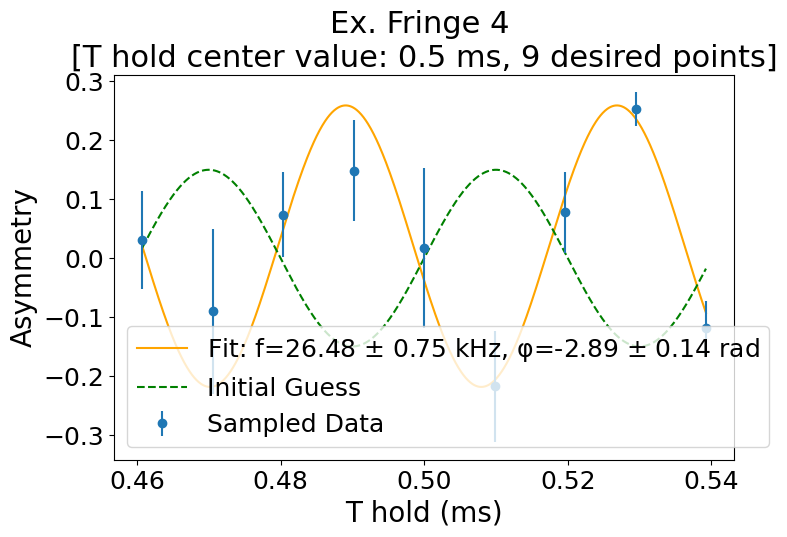

[ 2.02647010e-02  2.38999184e-01  2.64800621e+01 -2.89434050e+00]


In [586]:
freq_fit4, phi_fit4, freq_var4, phi_var4, freq_phi_cov4 = fit_sin_and_plot(t04s, avg04s, std04s, t4_center, p_init_3, 'Fringe 4')

In [695]:
def bootstrap_wrapper(t_range_prop, true_phase, 
                      prev_lin_fit, prev_error_lin_fit, 
                      prev_lin_fit_x_data, prev_lin_fit_y_data, prev_lin_fit_y_err,
                      new_phi_fit, new_phi_var, new_phi_x,
                      phase_options,
                      N, fig1_lim=[None,None], fig2_lim=[None,None], fig3_lim=[None,None]):
    potential_phis_tmp = np.array(phase_options)*np.pi + new_phi_fit
    pot_phi_xs_tmp = np.ones_like(potential_phis_tmp) * new_phi_x


    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    ax[0].plot(t_range_prop, prev_lin_fit/(np.pi), label='Fitted Phase')
    ax[0].fill_between(t_range_prop, (prev_lin_fit - prev_error_lin_fit)/np.pi, (prev_lin_fit + prev_error_lin_fit)/np.pi, color='orange', alpha=0.5, label=r'+/- 1$\sigma$ error')
    ax[0].errorbar(pot_phi_xs_tmp, potential_phis_tmp/(np.pi), yerr=np.sqrt(new_phi_var)/(np.pi), fmt='x', label=f'Potential Fringe {N} Fits', color='purple', markersize=10)
    ax[0].plot(t_range_prop, true_phase/(np.pi), label='True Phase', color='black', linestyle='--')
    ax[0].set_xlabel('Hold Time (ms)', fontsize=24)
    ax[0].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=24)

    ax[0].set_title(f'Fringe {N} Possible Measured Phase', fontsize=26)
    # ax[0].axvline(1.2, color='green', linestyle='--', label='1.2 ms')
    # ax[0].errorbar(center_t1_hold*1e3, (phi_fit)/(np.pi), yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point', markersize=10)



    good_phi_tmp = potential_phis_tmp[2]
    good_phi_x_tmp = new_phi_x
    good_phi_std_tmp = np.sqrt(new_phi_var)

    phi_lin_fit_x_data_new_tmp= np.append(prev_lin_fit_x_data, good_phi_x_tmp)
    phi_lin_fit_y_data_new_tmp= np.append(prev_lin_fit_y_data, good_phi_tmp)
    phi_lin_fit_y_err_new_tmp= np.append(prev_lin_fit_y_err, good_phi_std_tmp)


    ax[0].plot(phi_lin_fit_x_data_new_tmp, phi_lin_fit_y_data_new_tmp/np.pi, 'o', label='Chosen Points for Linear Fit', color='red', markersize=20, markerfacecolor='none')
    ax[0].set_xlim(fig1_lim[0])
    ax[0].set_ylim(fig1_lim[1])
    ax[0].grid()
    ax[0].legend(fontsize=18)



    # Fit line to data
    popt_lin_tmp, pcov_lin_tmp = curve_fit(phase_prop, phi_lin_fit_x_data_new_tmp, phi_lin_fit_y_data_new_tmp, sigma=phi_lin_fit_y_err_new_tmp)
    f_lin_fit_tmp, p_lin_fit_tmp = popt_lin_tmp
    f_lin_var_tmp, p_lin_var_tmp = np.diag(pcov_lin_tmp)
    fp_lin_cov_tmp = pcov_lin_tmp[0, 1]

    phase_prop_lin_fit_new_tmp = phase_prop(t_range_prop, f_lin_fit_tmp, p_lin_fit_tmp)
    error_prop_lin_fit_new_tmp = phase_error_prop(t_range_prop, f_lin_var_tmp, p_lin_var_tmp, fp_lin_cov_tmp)
    residuals_tmp = phi_lin_fit_y_data_new_tmp - phase_prop(phi_lin_fit_x_data_new_tmp, f_lin_fit_tmp, p_lin_fit_tmp)

    ax[1].errorbar(phi_lin_fit_x_data_new_tmp, phi_lin_fit_y_data_new_tmp/np.pi, yerr=phi_lin_fit_y_err_new_tmp/np.pi, fmt='o', label='Measured Points', color='red', markersize=10)
    ax[1].plot(t_range_prop, phase_prop_lin_fit_new_tmp/np.pi, label=f'Fitted Line, f={f_lin_fit_tmp:.3f}+/-{np.sqrt(f_lin_var_tmp):.3f}kHz', color='blue')
    ax[1].fill_between(t_range_prop, (phase_prop_lin_fit_new_tmp - error_prop_lin_fit_new_tmp)/np.pi, (phase_prop_lin_fit_new_tmp + error_prop_lin_fit_new_tmp)/np.pi, color='blue', alpha=0.2, label='Fit Uncertainty')
    ax[1].plot(t_range_prop, (true_phase)/np.pi, label='True Phase', color='black', linestyle='--')
    ax[1].set_xlabel('Hold Time (ms)', fontsize=24)
    # ax[1].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=24)  
    ax[1].set_title(f'Linear Fit to {N} Points', fontsize=26)
    ax[1].set_xlim(fig2_lim[0])
    ax[1].set_ylim(fig2_lim[1])
    ax[1].legend(fontsize=18)
    ax[1].grid()

    ax[2].fill_between(t_range_prop, error_prop_lin_fit_new_tmp/np.pi, -1*error_prop_lin_fit_new_tmp/np.pi, label=r'Linear Fit Phase Error (+/- 1$\sigma$)', color='blue', alpha=0.5)
    ax[2].errorbar(phi_lin_fit_x_data_new_tmp, residuals_tmp/np.pi, yerr=phi_lin_fit_y_err_new_tmp/np.pi, fmt='o', label='Measured Residuals', color='red', markersize=10)
    ax[2].plot(t_range_prop, (true_phase - phase_prop_lin_fit_new_tmp)/np.pi, label='True Phase Residual', color='black', linestyle='--')
    ax[2].set_xlabel('Hold Time (ms)', fontsize=24)
    # ax[2].set_ylabel(r'Deviation From Fit/$\pi$ (rad)', fontsize=24)
    ax[2].set_title('Residuals and Error Growth of Linear Fit', fontsize=26)
    ax[2].set_xlim(fig3_lim[0])
    ax[2].set_ylim(fig3_lim[1])
    ax[2].grid()
    ax[2].legend(fontsize=18)


    fig.suptitle(f'{N} Point Bootstrap', fontsize=30)
    plt.tight_layout()
    plt.show()

    return phase_prop_lin_fit_new_tmp, error_prop_lin_fit_new_tmp, phi_lin_fit_x_data_new_tmp, phi_lin_fit_y_data_new_tmp, phi_lin_fit_y_err_new_tmp


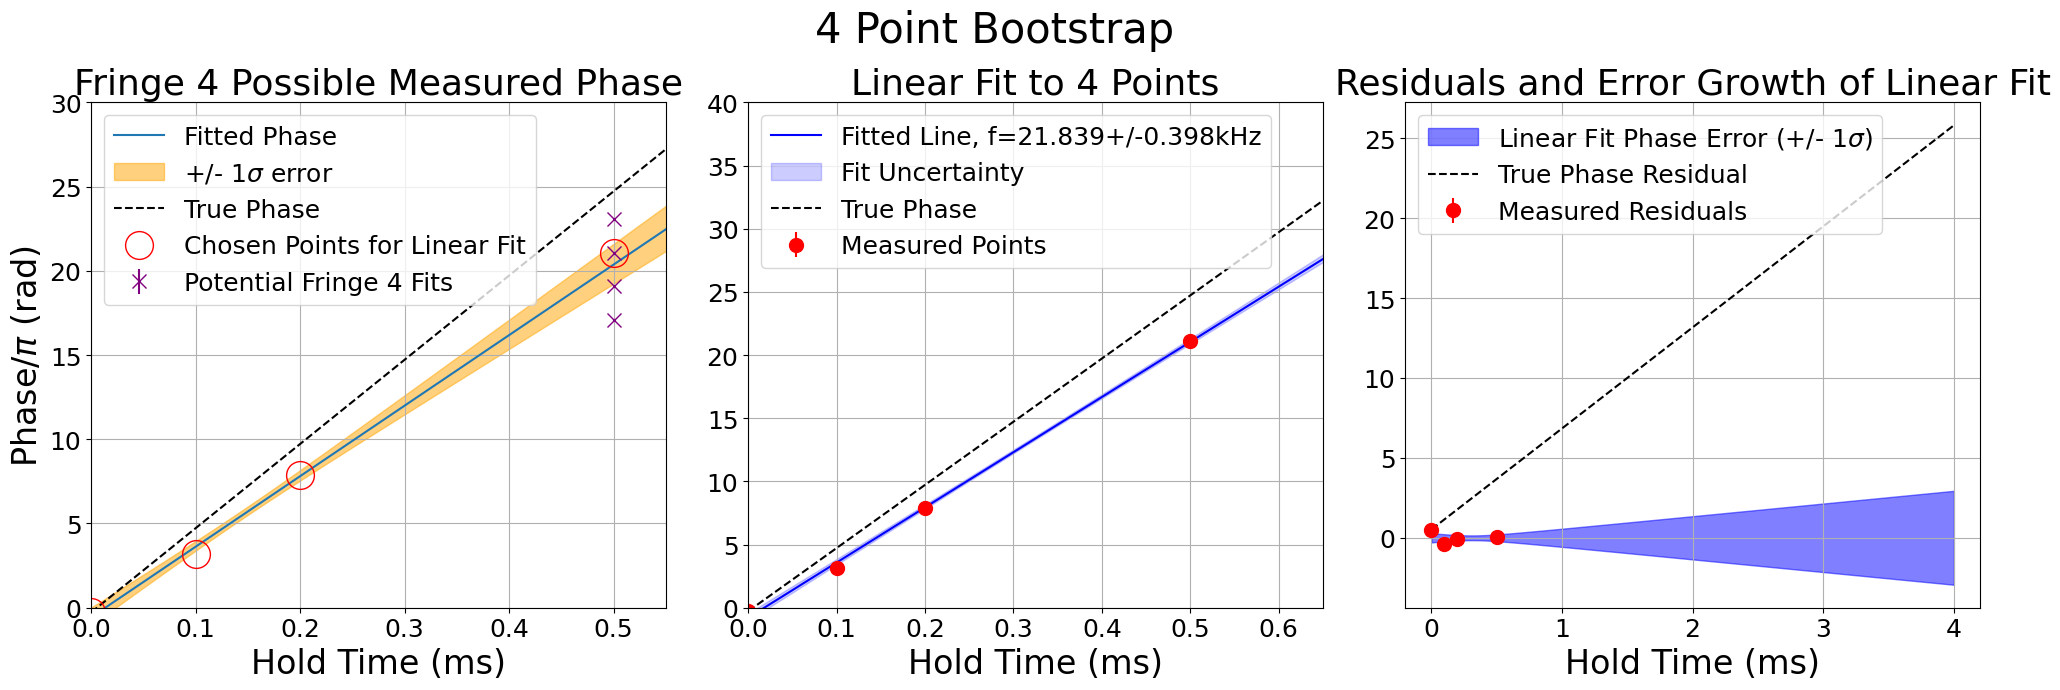

In [697]:
lin_fit_4, error_lin_fit_4, phi_lin_fit_x_data_4, phi_lin_fit_y_data_4, phi_lin_fit_y_err_4 = bootstrap_wrapper(t_range_prop, true_phase, 
                    phase_prop_lin_fit, error_prop_lin_fit,
                    phi_lin_fit_x_data, phi_lin_fit_y_data, phi_lin_fit_y_err,
                    phi_fit4, phi_var4, t4_center,
                    [18, 20, 22, 24],
                    4, fig1_lim=[[0,.55], [0,30]], fig2_lim=[[0,.65], [0,40]])

In [599]:
single_slit_times = t01s
single_slit_avgs = avg01s
single_slit_errs = err01s

two_slit_times = np.concatenate([t01s, t04s])
two_slit_avgs = np.concatenate([avg01s, avg04s])
two_slit_errs = np.concatenate([err01s, std04s])

three_slit_times = np.concatenate([t01s, t03s, t04s])
three_slit_avgs = np.concatenate([avg01s, avg03s, avg04s])
three_slit_errs = np.concatenate([err01s, std03s, std04s])

four_slit_times = np.concatenate([t01s, t02s, t03s, t04s])
four_slit_avgs = np.concatenate([avg01s, avg02s, avg03s, avg04s])
four_slit_errs = np.concatenate([err01s, std02s, std03s, std04s])

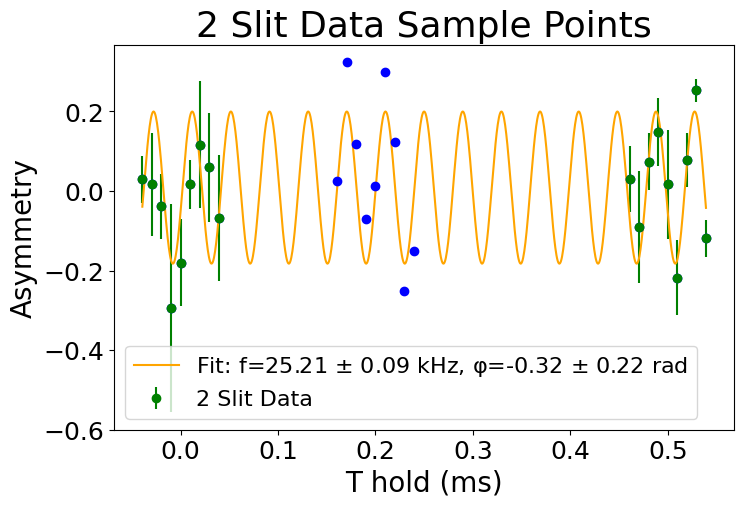

In [699]:
p_init_nu = [0, .15, f_1, 0]
popt_ex, pcov_ex = curve_fit(sin_func, two_slit_times, two_slit_avgs, p0=p_init_nu, sigma=two_slit_errs, absolute_sigma=True, bounds=sine_fit_bounds)
plot_ex_ts = np.linspace(two_slit_times[0], two_slit_times[-1], 1000)
fringe_fit = sin_func(plot_ex_ts, *popt_ex)
freq_fit_ex = popt_ex[2]
phi_fit_ex = popt_ex[3]
freq_var_ex = pcov_ex[2, 2]
phi_var_ex = pcov_ex[3, 3]
freq_phi_cov_ex = pcov_ex[2, 3]


plt.figure(figsize=(8, 5))
plt.errorbar(two_slit_times, two_slit_avgs, yerr=two_slit_errs, fmt='o', label='2 Slit Data', color='green')
plt.plot(plot_ex_ts, fringe_fit, color='orange', label=rf'Fit: f={freq_fit_ex:.2f} $\pm$ {np.sqrt(freq_var_ex):.2f} kHz, φ={phi_fit_ex:.2f} $\pm$ {np.sqrt(phi_var_ex):.2f} rad')
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.title('2 Slit Data Sample Points', fontsize=26)
plt.legend(fontsize=16)
plt.plot(three_slit_times, three_slit_avgs, 'o', label='3 Slit Data', color='blue')


In [649]:
def square_sin_error_weighted(time, data, data_sig, freqs, phis, want_2d):
    freq_errors=[]
    for f in freqs:
        phi_errors=[]
        for phi in phis: 
            phi_errors.append(np.sum(1/(data_sig**2) * (data - sin_func(time, 0, 0.15, f, phi))**2))
        if want_2d:
            freq_errors.append(phi_errors)
        else:
            freq_errors.append(np.min(phi_errors))
    return np.array(freq_errors)

In [650]:
phi_range = np.linspace(-np.pi, np.pi, 100)
freq_range = np.linspace(0, f_samp1/2, 1000)

print(phi_range.size)
print(single_slit_times.size)
print(freq_range.size)

ss_cost_2d = square_sin_error_weighted(single_slit_times, single_slit_avgs, single_slit_errs, freq_range, phi_range, want_2d=True)
ss_cost_mesh = np.meshgrid(phi_range, freq_range)
ss_cost_1d = square_sin_error_weighted(single_slit_times, single_slit_avgs, single_slit_errs, freq_range, phi_range, want_2d=False)

100
9
1000


In [652]:

ds_cost_2d = square_sin_error_weighted(two_slit_times, two_slit_avgs, two_slit_errs, freq_range, phi_range, want_2d=True)
ds_cost_1d = square_sin_error_weighted(two_slit_times, two_slit_avgs, two_slit_errs, freq_range, phi_range, want_2d=False)



### Error Ellipse Proceedure

1) get cov matrix and diagonalize to get the eigenvectors and eigenvalues ✅ 

2) Generate an axis aligned ellipse using the eigenvalues as the stand alone variances.  ✅ 

3) rotate the ellipse using the already normalized eigenvectors matrix!  ✅ 


In [654]:
def gen_ellipse(pcov_subspace, popt_subvector, s=5.991):
    
    # Get ellipse center
    x_0 = popt_subvector[0]  # frequency
    y_0 = popt_subvector[1]  # phase
    
    #get eigvals, eigvecs of cov matrix. Eigvals are the variances in pre-rotated frame!
    evals, evecs = np.linalg.eigh(pcov_subspace)

    # Generate ellipse parametrically not the stupid way I was trying before
    t = np.linspace(0, 2*np.pi, 100)
    a = np.sqrt(s * evals[0]) 
    b = np.sqrt(s * evals[1])
    x_std = a * np.cos(t)
    y_std = b * np.sin(t)

    # stack to prep for rotation by matrix mult
    points_std = np.vstack([x_std, y_std])
    
    # Eigvec matrix happens to be rotation matrix we need
    rotated_points = evecs @ points_std
    
    # Translate to be centered on the fit convergence value
    rotated_points[0] = rotated_points[0] + x_0
    rotated_points[1] = rotated_points[1] + y_0

    return rotated_points

In [655]:
popt, pcov = curve_fit(sin_func, two_slit_times, two_slit_avgs, p0=[0, .15, f_1, 0], sigma=two_slit_errs, absolute_sigma=True, bounds=sine_fit_bounds)

print(popt)
print('')
print('Covariance Matrix:')

print(pcov)

print('')
print('Just freq, phase')
print(popt[2:])
print('')
print('Just bottom 2x2 jordan block:')
print(pcov[2:, 2:])

print('')
print('Eigen results:')
evals, evecs = np.linalg.eigh(pcov[2:, 2:])
print('Eigenvalues:')
print(evals)
print('Eigenvectors:')
print(evecs)


print(evals.argmax())

sub_vec = popt[2:]
sub_mat = pcov[2:, 2:]

[ 8.59085155e-03  1.91217566e-01  2.52097871e+01 -3.21384526e-01]

Covariance Matrix:
[[ 0.00044236 -0.00028644  0.00073875 -0.00125979]
 [-0.00028644  0.00072427 -0.00044534  0.00099758]
 [ 0.00073875 -0.00044534  0.00754527 -0.01501723]
 [-0.00125979  0.00099758 -0.01501723  0.04641208]]

Just freq, phase
[25.2097871  -0.32138453]

Just bottom 2x2 jordan block:
[[ 0.00754527 -0.01501723]
 [-0.01501723  0.04641208]]

Eigen results:
Eigenvalues:
[0.00241906 0.05153829]
Eigenvectors:
[[-0.9463813  -0.32305175]
 [-0.32305175  0.9463813 ]]
1


In [657]:
# ...existing code...
def fit_and_plot(time, data, data_unc, init_guess, color, no, ax=None, method='trf'):
    """
    Fit a sine model and plot onto the provided matplotlib Axes.
    - ax: matplotlib.axes.Axes to plot on (defaults to current axes)
    - bounds: curve_fit bounds (defaults to sine_fit_bounds from outer scope)
    - method: curve_fit method (use 'trf' for bounds)
    """
    if ax is None:
        ax = plt.gca()

    popt, pcov = curve_fit(
        sin_func, time, data,
        p0=init_guess, sigma=data_unc, absolute_sigma=True,
        bounds=sine_fit_bounds, method=method
    )

    # Correct parameter reporting (A0, A, f, phi)
    A0, A, f, phi = popt
    dA0, dA, df, dphi = np.sqrt(np.diag(pcov))

    print(f'Fit {no} Results:')
    print(f'  Offset (A0): {A0:.3f} ± {dA0:.3f}')
    print(f'  Amplitude (A): {A:.3f} ± {dA:.3f}')
    print(f'  Frequency (f): {f:.3f} ± {df:.3f}')
    print(f'  Phase (phi): {phi:.3f} ± {dphi:.3f}')

    # Frequency-phase ellipse from 2x2 subspace
    sub_vec = popt[2:]
    sub_mat = pcov[2:, 2:]
    rot_ellipse = gen_ellipse(sub_mat, sub_vec)

    # Plot on the provided axes
    ax.plot(rot_ellipse[0], rot_ellipse[1]/np.pi, label=f'Fit {no} Ellipse', color=color)
    ax.plot(f, phi/np.pi, '*', label=f'Fit {no} Convergence', color=color, markersize=10)
    ax.plot(np.array([init_guess[2], f]), np.array([init_guess[3], phi])/np.pi,
            label=f'Fit {no} Path', color=color, linestyle='--')

    return popt, pcov

In [658]:
def find_global_min(cost_2d, freq_range, phi_range):
    global_min_idx = np.unravel_index(np.argmin(cost_2d), cost_2d.shape)
    return freq_range[global_min_idx[0]], phi_range[global_min_idx[1]]  
print(find_global_min(ss_cost_2d, freq_range, phi_range/np.pi))

(19.642239188377108, -0.33333333333333326)


Fit 1 Results:
  Offset (A0): 0.009 ± 0.021
  Amplitude (A): 0.191 ± 0.027
  Frequency (f): 25.210 ± 0.087
  Phase (phi): -0.322 ± 0.215
Fit 2 Results:
  Offset (A0): 0.008 ± 0.021
  Amplitude (A): 0.187 ± 0.027
  Frequency (f): 23.430 ± 0.088
  Phase (phi): -0.722 ± 0.212


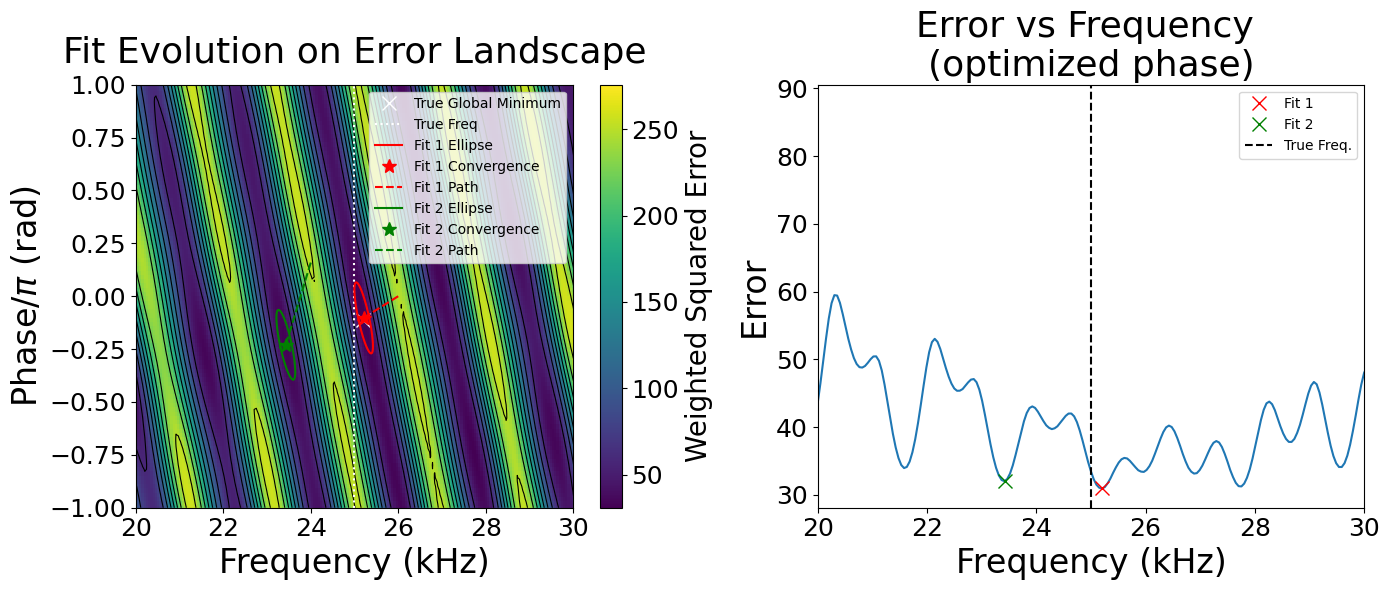

In [ ]:
# plt.pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto', norm=colors.LogNorm())

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

im = ax[0].pcolormesh(ss_cost_mesh[1], ss_cost_mesh[0]/(np.pi), ds_cost_2d, shading='auto')
levels = np.linspace(ds_cost_2d.min(), ds_cost_2d.max(), 10)
cs = ax[0].contour(ss_cost_mesh[1], ss_cost_mesh[0]/np.pi, ds_cost_2d,
                   levels=levels, colors='k', linewidths=0.8)
# ax[0].clabel(cs, fmt='%.2g', fontsize=8)
fig.colorbar(im, ax=ax[0], label='Weighted Squared Error')


min_freq, min_phi = find_global_min(ds_cost_2d, freq_range, phi_range/np.pi)
ax[0].plot(min_freq, min_phi, 'x', label='True Global Minimum', color='w', markersize=10)
ax[0].axvline(f_1, 0, label='True Freq', color='w', linestyle=':')

popt0, pcov0 = fit_and_plot(two_slit_times, two_slit_avgs, two_slit_errs, [0, .15, 26, 0], 'r', 1, ax=ax[0])
popt1, pcov1 = fit_and_plot(two_slit_times, two_slit_avgs, two_slit_errs, [0, .15, 24, 0.5], 'g', 2, ax=ax[0])


ax[0].set_xlim(20,30)
ax[0].set_ylim(-1,1)
ax[0].legend()
ax[0].set_title('Fit Evolution on Error Landscape', fontsize=26, pad=16)
ax[0].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=24)
ax[0].set_xlabel('Frequency (kHz)', fontsize=24)


ax[1].plot(freq_range, ds_cost_1d)
ax[1].plot(popt0[2], ds_cost_1d[np.abs(freq_range - popt0[2]).argmin()], 'x', label='Fit 1', color='r', markersize=10)
ax[1].plot(popt1[2], ds_cost_1d[np.abs(freq_range - popt1[2]).argmin()], 'x', label='Fit 2', color='g', markersize=10)
ax[1].axvline(25, color='black', linestyle='--', label='True Freq.')

ax[1].set_title('Error vs Frequency \n(optimized phase)', fontsize=26)
ax[1].set_ylabel('Error', fontsize=24)
ax[1].set_xlabel('Frequency (kHz)', fontsize=24)
ax[1].set_xlim(20,30)
ax[1].legend()  
fig.tight_layout()

In [684]:
fit1_f, fit1_phi = popt0[2], popt0[3]
fit1_f_err, fit1_phi_err = np.sqrt(pcov0[2,2]), np.sqrt(pcov0[3,3])
print(f'Fit F1: {fit1_f:.3f} +/- {fit1_f_err:.3f} kHz')
print(f'Fit Phi1: {fit1_phi:.3f} +/- {fit1_phi_err:.3f} rads')

Fit F1: 25.210 +/- 0.087 kHz
Fit Phi1: -0.322 +/- 0.215 rads


In [685]:
fs_cost_2d = square_sin_error_weighted(four_slit_times, four_slit_avgs, four_slit_errs, freq_range, phi_range, want_2d=True)
fs_cost_1d = square_sin_error_weighted(four_slit_times, four_slit_avgs, four_slit_errs, freq_range, phi_range, want_2d=False)

Fit 1 Results:
  Offset (A0): 0.010 ± 0.015
  Amplitude (A): 0.177 ± 0.020
  Frequency (f): 25.145 ± 0.080
  Phase (phi): -0.143 ± 0.159


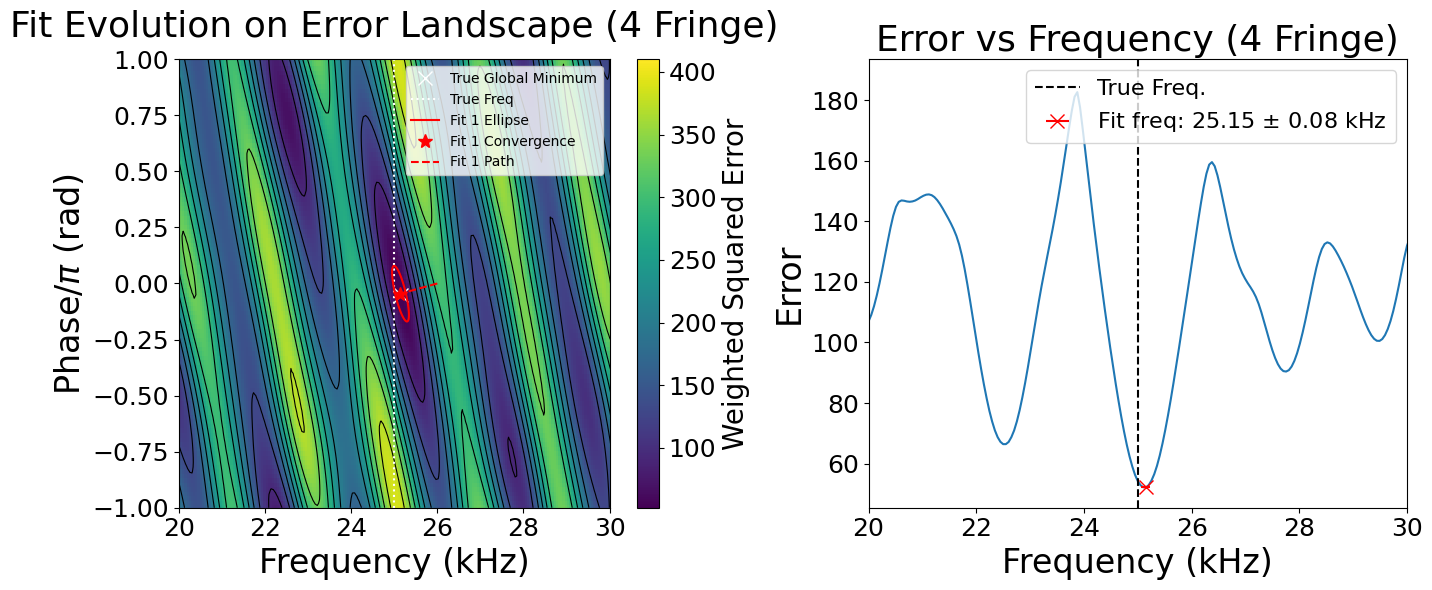

In [698]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

im2 = ax[0].pcolormesh(ss_cost_mesh[1], ss_cost_mesh[0]/(np.pi), fs_cost_2d, shading='auto')
levels = np.linspace(fs_cost_2d.min(), fs_cost_2d.max(), 10)
cs = ax[0].contour(ss_cost_mesh[1], ss_cost_mesh[0]/np.pi, fs_cost_2d,
                   levels=levels, colors='k', linewidths=0.8)
# ax[0].clabel(cs, fmt='%.2g', fontsize=8)
fig.colorbar(im2, ax=ax[0], label='Weighted Squared Error')


min_freq2, min_phi2 = find_global_min(fs_cost_2d, freq_range, phi_range/np.pi)
ax[0].plot(min_freq2, min_phi2, 'x', label='True Global Minimum', color='w', markersize=10)
ax[0].axvline(f_1, 0, label='True Freq', color='w', linestyle=':')

popt0, pcov0 = fit_and_plot(four_slit_times, four_slit_avgs, four_slit_errs, [0, .15, 26, 0], 'r', 1, ax=ax[0])
# popt1, pcov1 = fit_and_plot(four_slit_times, four_slit_avgs, four_slit_errs, [0, .15, 24, 0.5], 'g', 2, ax=ax[0])


ax[0].set_xlim(20,30)
ax[0].set_ylim(-1,1)
ax[0].legend()
ax[0].set_title('Fit Evolution on Error Landscape (4 Fringe)', fontsize=26, pad=16)
ax[0].set_ylabel(r'Phase/$\pi$ (rad)', fontsize=24)
ax[0].set_xlabel('Frequency (kHz)', fontsize=24)


ax[1].plot(freq_range, fs_cost_1d)
ax[1].errorbar(popt0[2], fs_cost_1d[np.abs(freq_range - popt0[2]).argmin()], xerr=pcov0[2,2]**0.5, fmt='x', label=rf'Fit freq: {popt0[2]:.2f} $\pm$ {pcov0[2,2]**0.5:.2f} kHz', color='r', markersize=10)
# ax[1].plot(popt1[2], fs_cost_1d[np.abs(freq_range - popt1[2]).argmin()], 'x', label='Fit 2', color='g', markersize=10)
ax[1].axvline(25, color='black', linestyle='--', label='True Freq.')

ax[1].set_title('Error vs Frequency (4 Fringe)', fontsize=26)
ax[1].set_ylabel('Error', fontsize=24)
ax[1].set_xlabel('Frequency (kHz)', fontsize=24)
ax[1].set_xlim(20,30)
ax[1].legend(fontsize=16)  
fig.tight_layout()

In [774]:
t1s, avg1s, err1s = gen_sample(little_g_fringe, 0, f_samp1, 9, noise_level=0.01)
t2s, avg2s, err2s = gen_sample(little_g_fringe, 0.8, f_samp1, 9, noise_level=0.01)
t3s, avg3s, err3s = gen_sample(little_g_fringe, 1.6, f_samp1, 9, noise_level=0.01)
t4s, avg4s, err4s = gen_sample(little_g_fringe, 3.2, f_samp1, 9, noise_level=0.01)
t5s, avg5s, err5s = gen_sample(little_g_fringe, 6.4, f_samp1, 9, noise_level=0.01)


In [822]:
double_times = np.concatenate([t1s, t5s])
double_avgs = np.concatenate([avg1s, avg5s])
double_errs = np.concatenate([err1s, err5s])

triple_times = np.concatenate([t1s, t4s, t5s])
triple_avgs = np.concatenate([avg1s, avg4s, avg5s])
triple_errs = np.concatenate([err1s, err4s, err5s])

dense_freq_range = np.linspace(20,30,10000)

In [820]:
double_cost_1d = square_sin_error_weighted(double_times, double_avgs, double_errs, dense_freq_range, phi_range, want_2d=False)
triple_cost_1d = square_sin_error_weighted(triple_times, triple_avgs, triple_errs, dense_freq_range, phi_range, want_2d=False)

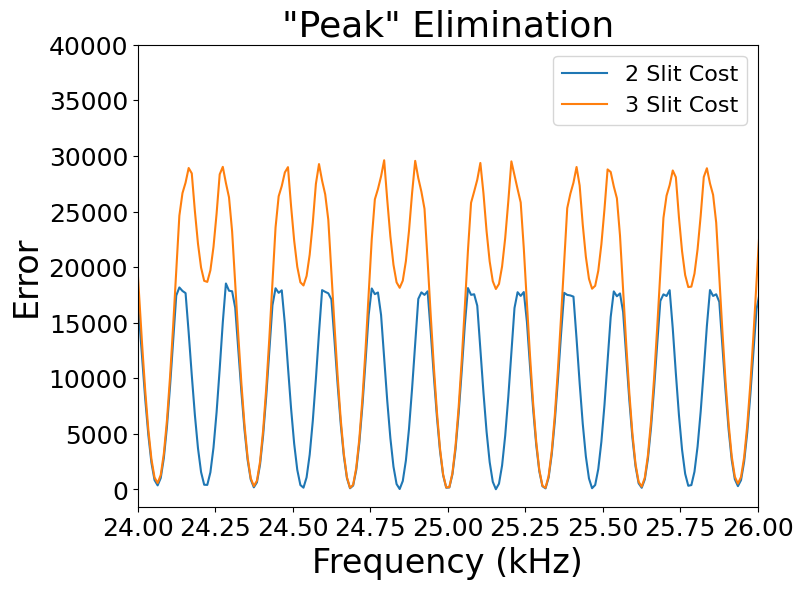

In [821]:
plt.figure(figsize=(8,6))
plt.plot(dense_freq_range, double_cost_1d, label='2 Slit Cost')
plt.plot(dense_freq_range, triple_cost_1d, label='3 Slit Cost')
plt.xlabel('Frequency (kHz)', fontsize=24)
plt.ylabel('Error', fontsize=24)
plt.title('"Peak" Elimination', fontsize=26)
plt.xlim(24,26)
plt.ylim(None,40000)
plt.legend(fontsize=16)

In [796]:
full_times = np.concatenate([t1s, t2s, t3s, t4s, t5s])
full_avgs = np.concatenate([avg1s, avg2s, avg3s, avg4s, avg5s])
full_errs = np.concatenate([err1s, err2s, err3s, err4s, err5s])

In [797]:
full_cost_1d = square_sin_error_weighted(full_times, full_avgs, full_errs, dense_freq_range, phi_range, want_2d=False)

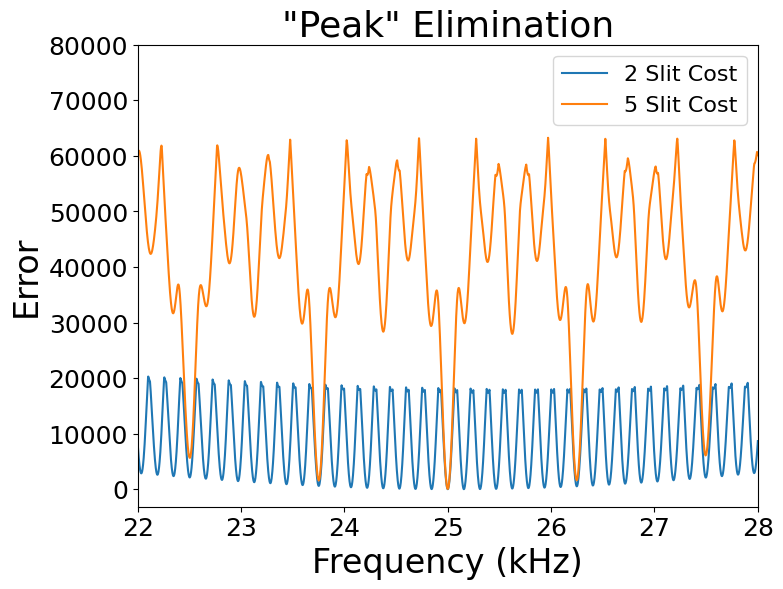

In [801]:
plt.figure(figsize=(8,6))
plt.plot(dense_freq_range, double_cost_1d, label='2 Slit Cost')
plt.plot(dense_freq_range, full_cost_1d, label='5 Slit Cost')
plt.xlabel('Frequency (kHz)', fontsize=24)
plt.ylabel('Error', fontsize=24)
plt.title('"Peak" Elimination', fontsize=26)
plt.xlim(22,28)
plt.ylim(None,80000)
plt.legend(fontsize=16)

In [811]:
t1s_n, avg1s_n, err1s_n = gen_sample(little_g_fringe, 0, f_samp1, 9, noise_level=0.2)
t2s_n, avg2s_n, err2s_n = gen_sample(little_g_fringe, 0.8, f_samp1, 9, noise_level=0.2)
t3s_n, avg3s_n, err3s_n = gen_sample(little_g_fringe, 1.6, f_samp1, 9, noise_level=0.2)
t4s_n, avg4s_n, err4s_n = gen_sample(little_g_fringe, 3.2, f_samp1, 9, noise_level=0.2)
t5s_n, avg5s_n, err5s_n = gen_sample(little_g_fringe, 6.4, f_samp1, 9, noise_level=0.2)


ds_times_noisy = np.concatenate([t1s_n, t5s_n])
ds_avgs_noisy = np.concatenate([avg1s_n, avg5s_n])
ds_errs_noisy = np.concatenate([err1s_n, err5s_n])


full_times_noisy = np.concatenate([t1s_n, t2s_n, t3s_n, t4s_n, t5s_n])
full_avgs_noisy = np.concatenate([avg1s_n, avg2s_n, avg3s_n, avg4s_n, avg5s_n])
full_errs_noisy = np.concatenate([err1s_n, err2s_n, err3s_n, err4s_n, err5s_n])

In [812]:
full_cost_1d_noisy = square_sin_error_weighted(full_times_noisy, full_avgs_noisy, full_errs_noisy, dense_freq_range, phi_range, want_2d=False)
ds_cost_1d_noisy = square_sin_error_weighted(ds_times_noisy, ds_avgs_noisy, ds_errs_noisy, dense_freq_range, phi_range, want_2d=False)

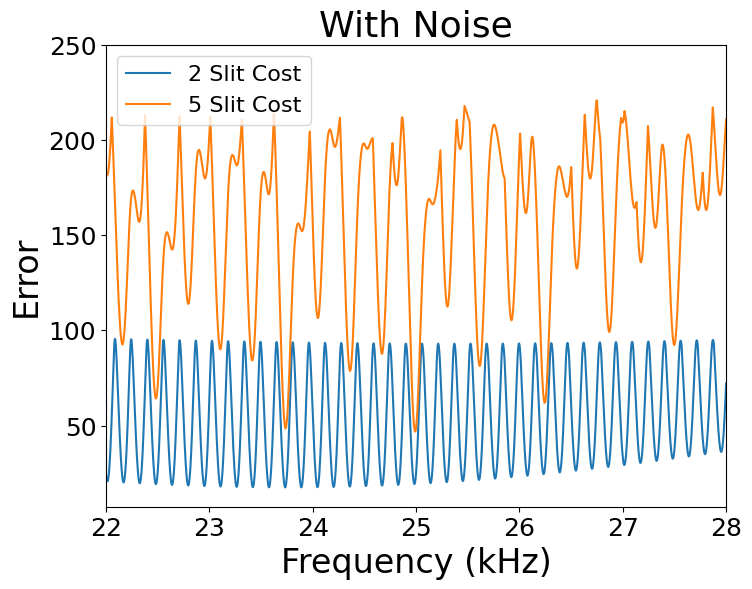

In [815]:
plt.figure(figsize=(8,6))
plt.plot(dense_freq_range, ds_cost_1d_noisy, label='2 Slit Cost')
plt.plot(dense_freq_range, full_cost_1d_noisy, label='5 Slit Cost')
plt.xlabel('Frequency (kHz)', fontsize=24)
plt.ylabel('Error', fontsize=24)
plt.title('With Noise', fontsize=26)
plt.xlim(22,28)
plt.ylim(None,250)
plt.legend(fontsize=16)

In [825]:
mid_freq_range = np.linspace(20,30,2000)

In [829]:

def run_stats(N, lvl):
    all_costs = []
    for i in range(N):
        print('Trial ', i+1)
        t1s_n, avg1s_n, err1s_n = gen_sample(little_g_fringe, 0, f_samp1, 9, noise_level=lvl)
        t2s_n, avg2s_n, err2s_n = gen_sample(little_g_fringe, 0.8, f_samp1, 9, noise_level=lvl)
        t3s_n, avg3s_n, err3s_n = gen_sample(little_g_fringe, 1.6, f_samp1, 9, noise_level=lvl)
        t4s_n, avg4s_n, err4s_n = gen_sample(little_g_fringe, 3.2, f_samp1, 9, noise_level=lvl)
        t5s_n, avg5s_n, err5s_n = gen_sample(little_g_fringe, 6.4, f_samp1, 9, noise_level=lvl)

        full_times_noisy = np.concatenate([t1s_n, t2s_n, t3s_n, t4s_n, t5s_n])
        full_avgs_noisy = np.concatenate([avg1s_n, avg2s_n, avg3s_n, avg4s_n, avg5s_n])
        full_errs_noisy = np.concatenate([err1s_n, err2s_n, err3s_n, err4s_n, err5s_n])

        all_costs.append(square_sin_error_weighted(full_times_noisy, full_avgs_noisy, full_errs_noisy, mid_freq_range, phi_range, want_2d=False))
    return np.array(all_costs)


In [843]:
all_costs_lvl1 = run_stats(50, 0.2)

Trial  1
Trial  2
Trial  3
Trial  4
Trial  5
Trial  6
Trial  7
Trial  8
Trial  9
Trial  10
Trial  11
Trial  12
Trial  13
Trial  14
Trial  15
Trial  16
Trial  17
Trial  18
Trial  19
Trial  20
Trial  21
Trial  22
Trial  23
Trial  24
Trial  25
Trial  26
Trial  27
Trial  28
Trial  29
Trial  30
Trial  31
Trial  32
Trial  33
Trial  34
Trial  35
Trial  36
Trial  37
Trial  38
Trial  39
Trial  40
Trial  41
Trial  42
Trial  43
Trial  44
Trial  45
Trial  46
Trial  47
Trial  48
Trial  49
Trial  50


In [844]:
avg_lvl1 = np.mean(all_costs_lvl1, axis=0)
mins_lvl1 = np.min(all_costs_lvl1, axis=0)
maxs_lvl1 = np.max(all_costs_lvl1, axis=0)
stds_lvl1 = np.std(all_costs_lvl1, axis=0)


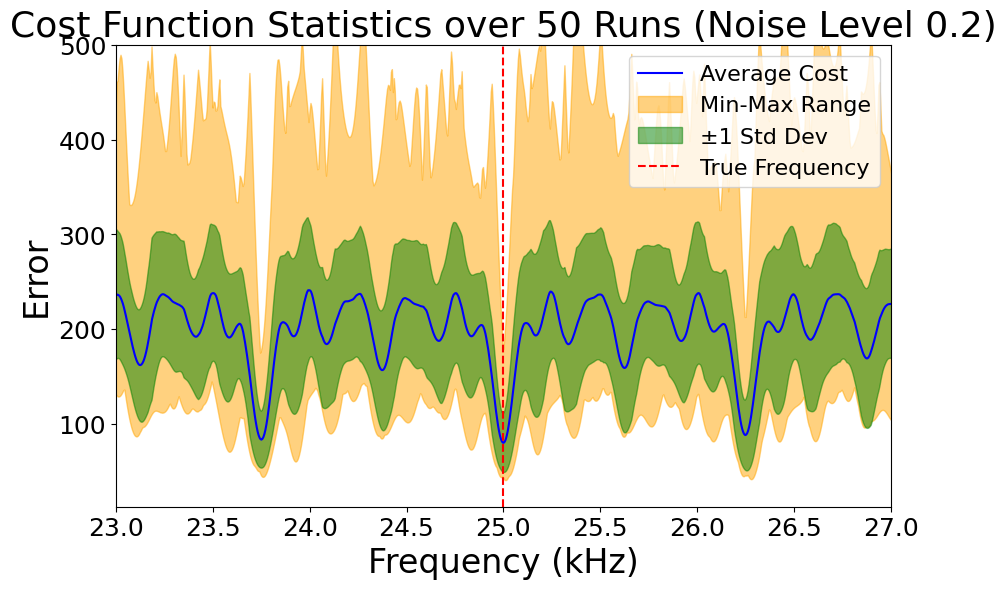

In [846]:
plt.figure(figsize=(10, 6))
plt.plot(mid_freq_range, avg_lvl1, label='Average Cost', color='blue')
plt.fill_between(mid_freq_range, mins_lvl1, maxs_lvl1, color='orange', alpha=0.5, label='Min-Max Range')
plt.fill_between(mid_freq_range, avg_lvl1 - stds_lvl1, avg_lvl1 + stds_lvl1, color='green', alpha=0.5, label='±1 Std Dev')
plt.axvline(f_1, color='red', linestyle='--', label='True Frequency')
plt.xlabel('Frequency (kHz)', fontsize=24)
plt.ylabel('Error', fontsize=24)
plt.title('Cost Function Statistics over 50 Runs (Noise Level 0.2)', fontsize=26)
plt.xlim(23,27)
plt.ylim(None,500)
plt.legend(fontsize=16) 

In [853]:
t1s_x, avg1s_x, err1s_x = gen_sample(little_g_fringe, 0, f_samp1, 9, noise_level=0.1)
popt_1x, pcov_1x = curve_fit(sin_func, t1s_x, avg1s_x, p0=[0, .15, f_1, 0], sigma=err1s_x, absolute_sigma=True, bounds=sine_fit_bounds)


In [857]:
t2s_x, avg2s_x, err2s_x = gen_sample(little_g_fringe, 0, f_samp1, 9, noise_level=0.3)
popt_2x, pcov_2x = curve_fit(sin_func, t2s_x, avg2s_x, p0=[0, .15, f_1, 0], sigma=err2s_x, absolute_sigma=True, bounds=sine_fit_bounds)


Text(0, 0.5, 'Asymmetry')

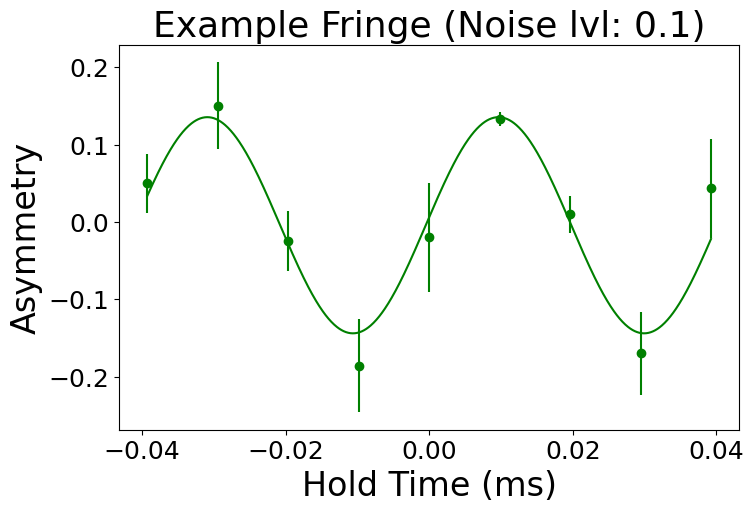

In [856]:
plt.figure(figsize=(8,5))
plt.title("Example Fringe (Noise lvl: 0.1)", fontsize=26)
plt.errorbar(t1s_x, avg1s_x, err1s_x, fmt='o', color='g', label='Data')
plt.plot(np.linspace(t1s_x[0], t1s_x[-1], 1000), sin_func(np.linspace(t1s_x[0], t1s_x[-1], 1000), *popt_1x), label='Fit', color='g')
plt.xlabel('Hold Time (ms)', fontsize=24)
plt.ylabel('Asymmetry', fontsize=24)


Text(0, 0.5, 'Asymmetry')

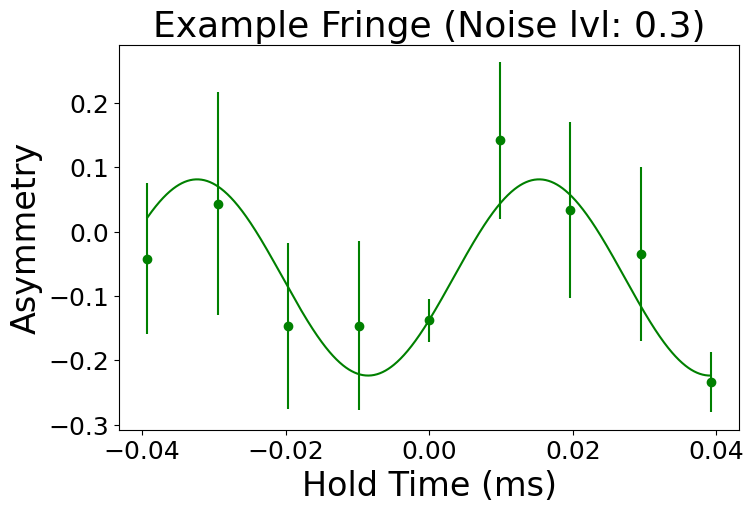

In [858]:
plt.figure(figsize=(8,5))
plt.title("Example Fringe (Noise lvl: 0.3)", fontsize=26)
plt.errorbar(t2s_x, avg2s_x, err2s_x, fmt='o', color='g', label='Data')
plt.plot(np.linspace(t2s_x[0], t2s_x[-1], 1000), sin_func(np.linspace(t2s_x[0], t2s_x[-1], 1000), *popt_2x), label='Fit', color='g')
plt.xlabel('Hold Time (ms)', fontsize=24)
plt.ylabel('Asymmetry', fontsize=24)
